In [22]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-$(python -c "import torch; print(torch.__version__)").html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-$(python -c "import torch; print(torch.__version__)").html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-$(python -c "import torch; print(torch.__version__)").html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-$(python -c "import torch; print(torch.__version__)").html
!pip install torch-geometric

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader
from torch_geometric.nn import GCNConv
import cv2
import numpy as np
from PIL import Image
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.model_selection import train_test_split
from torch_geometric.utils import dense_to_sparse, add_self_loops


Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html


In [23]:

# Connect to google drive
from google.colab import drive
drive.mount('/content/drive/')

# Adding your absolute path of your project folder to system path
import sys
sys.path.append("/content/drive/My Drive/Multi_Label_dataset")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [24]:
%cd "/content/drive/My Drive/Multi_Label_dataset"

/content/drive/My Drive/Multi_Label_dataset


In [25]:
# Checking status of gpu available through google collab
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [26]:
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

class ImageDataset(Dataset):
    def __init__(self, csv, train=True, test=False, image_dir="/content/drive/My Drive/Multi_Label_dataset/Images"):
        self.csv = csv
        self.train = train
        self.test = test
        self.image_dir = image_dir

        # Image ID and labels
        self.all_image_names = self.csv['Id']
        self.all_labels = np.array(self.csv.drop(['Id', 'Genre'], axis=1))

        # Train-validation split
        self.train_ratio = int(0.85 * len(self.csv))
        self.valid_ratio = len(self.csv) - self.train_ratio

        if self.train:
            print(f"Number of training images: {self.train_ratio}")
            self.image_names = list(self.all_image_names[:self.train_ratio])
            self.labels = list(self.all_labels[:self.train_ratio])
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=45),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            ])
        elif not self.train and not self.test:
            print(f"Number of validation images: {self.valid_ratio}")
            self.image_names = list(self.all_image_names[-self.valid_ratio:-10])
            self.labels = list(self.all_labels[-self.valid_ratio:-10])
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
            ])
        elif self.test:
            self.image_names = list(self.all_image_names[-10:])
            self.labels = list(self.all_labels[-10:])
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor(),
            ])

        # Filter valid samples
        self._filter_valid_samples()

    def _filter_valid_samples(self):
        valid_samples = []
        for i in range(len(self.image_names)):
            img_path = f"{self.image_dir}/{self.image_names[i]}.jpg"
            if os.path.exists(img_path):
                valid_samples.append((self.image_names[i], self.labels[i]))
            else:
                print(f"Skipping missing file: {img_path}")
        if valid_samples:
            self.image_names, self.labels = zip(*valid_samples)
        else:
            self.image_names, self.labels = [], []

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index):
        img_path = f"{self.image_dir}/{self.image_names[index]}.jpg"
        image = cv2.imread(img_path)

        # Handle missing or unreadable files gracefully
        if image is None:
            print(f"Warning: Unable to read image: {img_path}")
            return None, None

        # Convert image from BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply image transforms
        image = self.transform(image)
        targets = self.labels[index]

        return {
            'image': image.clone().detach() if isinstance(image, torch.Tensor) else torch.tensor(image, dtype=torch.float32),
            'label': torch.tensor(targets, dtype=torch.float32)
        }


In [27]:

class CNNGCNModel(nn.Module):
    def __init__(self, num_classes, edge_index, cnn_output_dim=256, gcn_hidden_dim=128):
        super(CNNGCNModel, self).__init__()

        # CNN Component
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(128 * 56 * 56, cnn_output_dim),  # Ensure dimensions match
            nn.ReLU()
        )

        # GCN Component
        self.gcn1 = GCNConv(num_classes, gcn_hidden_dim)
        self.gcn2 = GCNConv(gcn_hidden_dim, cnn_output_dim)

        # Edge index
        self.edge_index = edge_index

    def forward(self, x, label_features):
        # CNN forward pass
        cnn_features = self.cnn(x)
        print(f"CNN Features Shape: {cnn_features.shape}")

        # GCN forward pass
        label_embeddings = self.gcn1(label_features, self.edge_index)
        print(f"GCN1 Output: {label_embeddings}")
        label_embeddings = F.relu(label_embeddings)

        label_embeddings = self.gcn2(label_embeddings, self.edge_index)
        print(f"GCN2 Output: {label_embeddings}")
        label_embeddings = F.relu(label_embeddings)

        # Combine CNN and GCN outputs
        logits = torch.matmul(cnn_features, label_embeddings.T)
        return logits


def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)






In [28]:

# Load the CSV file
csv_file = pd.read_csv("train.csv")  # Ensure the CSV matches the expected format

# Split the CSV into train and validation
train_csv, val_csv = train_test_split(csv_file, test_size=0.15, random_state=42)

# Define the paths
image_dir = "/content/drive/My Drive/Multi_Label_dataset/Images"

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define the collate_fn function before its usage
def collate_fn(batch):
    # Filter out None values
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return None
    images = torch.stack([item['image'] for item in batch])
    labels = torch.stack([item['label'] for item in batch])
    return {'image': images, 'label': labels}

# Create Dataset and DataLoader
train_dataset = ImageDataset(train_csv, train=True)
val_dataset = ImageDataset(val_csv, train=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Label Graph (example adjacency matrix)
num_classes = train_csv.drop(['Id', 'Genre'], axis=1).shape[1]
label_graph_adj = torch.eye(num_classes)
edge_index, _ = dense_to_sparse(label_graph_adj)
edge_index, _ = add_self_loops(edge_index, num_nodes=num_classes)
label_features = torch.eye(num_classes)



# Define the model
model = CNNGCNModel(num_classes=num_classes, edge_index=edge_index)
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy for multi-label classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Store losses for plotting
train_losses = []
val_losses = []



# Initialize Datasets
train_dataset = ImageDataset(train_csv, train=True)
val_dataset = ImageDataset(val_csv, train=False)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Training loop
for epoch in range(10):  # Number of epochs
    model.train()  # Set the model to training mode
    total_train_loss = 0
    count = 0

    for batch in train_loader:  # Iterate over batches
        if batch is None:  # Handle invalid batches (if any)
            continue

        images = batch['image']
        labels = batch['label']

        optimizer.zero_grad()  # Clear gradients from the previous step
        logits = model(images, label_features)  # Forward pass
        loss = criterion(logits, labels)  # Compute the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_train_loss += loss.item()  # Accumulate loss
        count += 1

    # Compute average loss for the epoch
    avg_train_loss = total_train_loss / count if count > 0 else float('inf')
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss}")

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            if batch is None:  # Handle invalid batches (if any)
                continue

            images = batch['image']
            labels = batch['label']
            logits = model(images, label_features)
            loss = criterion(logits, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")






Streaming output truncated to the last 5000 lines.
Skipping missing file: /content/drive/My Drive/Multi_Label_dataset/Images/tt0100157.jpg
Skipping missing file: /content/drive/My Drive/Multi_Label_dataset/Images/tt0162346.jpg
Skipping missing file: /content/drive/My Drive/Multi_Label_dataset/Images/tt0765447.jpg
Skipping missing file: /content/drive/My Drive/Multi_Label_dataset/Images/tt0096316.jpg
Skipping missing file: /content/drive/My Drive/Multi_Label_dataset/Images/tt0465551.jpg
Skipping missing file: /content/drive/My Drive/Multi_Label_dataset/Images/tt0117784.jpg
Skipping missing file: /content/drive/My Drive/Multi_Label_dataset/Images/tt0978764.jpg
Skipping missing file: /content/drive/My Drive/Multi_Label_dataset/Images/tt1351685.jpg
Skipping missing file: /content/drive/My Drive/Multi_Label_dataset/Images/tt0492956.jpg
Skipping missing file: /content/drive/My Drive/Multi_Label_dataset/Images/tt0112572.jpg
Skipping missing file: /content/drive/My Drive/Multi_Label_dataset/Im

KeyboardInterrupt: 

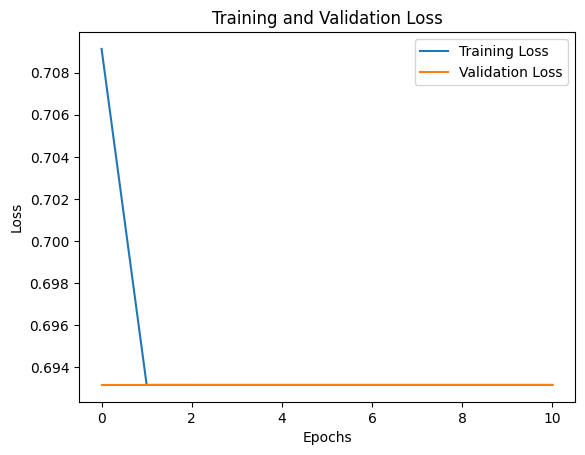

In [29]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


In [30]:
from sklearn.metrics import average_precision_score

# Evaluate mAP
model.eval()
all_logits = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        images = batch['image']
        labels = batch['label']
        logits = model(images, label_features)
        all_logits.append(torch.sigmoid(logits).cpu().numpy())  # Sigmoid for probabilities
        all_labels.append(labels.cpu().numpy())

# Concatenate all batches
all_logits = np.vstack(all_logits)
all_labels = np.vstack(all_labels)

# Compute mAP
mAP = average_precision_score(all_labels, all_logits, average="macro")
print(f"Validation mAP: {mAP}")


CNN Features Shape: torch.Size([6, 256])
GCN1 Output: tensor([[-0.1548, -0.0608,  0.0042,  ..., -0.0181,  0.0522, -0.0840],
        [ 0.1556,  0.0949, -0.1970,  ...,  0.1611,  0.1920,  0.1547],
        [ 0.0968,  0.1116,  0.1324,  ..., -0.1959,  0.0440,  0.1400],
        ...,
        [ 0.0536, -0.0231, -0.1518,  ..., -0.1480,  0.1337,  0.0122],
        [-0.1520, -0.1622,  0.0869,  ..., -0.1050,  0.1272,  0.0339],
        [ 0.1827, -0.0819,  0.0266,  ..., -0.0445,  0.0787, -0.1301]])
GCN2 Output: tensor([[-0.0300, -0.1351, -0.0674,  ..., -0.0517,  0.0379, -0.0374],
        [-0.0842, -0.0820, -0.1983,  ..., -0.1041,  0.0662, -0.0847],
        [-0.0877, -0.1062, -0.0400,  ...,  0.0208, -0.0277, -0.0082],
        ...,
        [-0.0379, -0.1450, -0.1288,  ..., -0.1617, -0.0039, -0.0538],
        [-0.1110, -0.1238, -0.0963,  ..., -0.0162, -0.0262, -0.0468],
        [-0.0612, -0.1261, -0.0290,  ..., -0.0511, -0.0490, -0.0603]])
Validation mAP: 0.09333333333333332


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive c

Streaming output truncated to the last 5000 lines.
Skipping missing file: /content/drive/My Drive/Multi_Label_dataset/Images/tt1949178.jpg
Skipping missing file: /content/drive/My Drive/Multi_Label_dataset/Images/tt0094315.jpg
Skipping missing file: /content/drive/My Drive/Multi_Label_dataset/Images/tt0119560.jpg
Skipping missing file: /content/drive/My Drive/Multi_Label_dataset/Images/tt0785007.jpg
Skipping missing file: /content/drive/My Drive/Multi_Label_dataset/Images/tt0116762.jpg
Skipping missing file: /content/drive/My Drive/Multi_Label_dataset/Images/tt0201485.jpg
Skipping missing file: /content/drive/My Drive/Multi_Label_dataset/Images/tt0090848.jpg
Skipping missing file: /content/drive/My Drive/Multi_Label_dataset/Images/tt0397892.jpg
Skipping missing file: /content/drive/My Drive/Multi_Label_dataset/Images/tt0482606.jpg
Skipping missing file: /content/drive/My Drive/Multi_Label_dataset/Images/tt0092172.jpg
Skipping missing file: /content/drive/My Drive/Multi_Label_dataset/Im

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive c

CNN Features Shape: torch.Size([32, 256])
GCN Intermediate Label Embeddings Shape: torch.Size([25, 128])
GCN Final Label Embeddings Shape: torch.Size([25, 256])
Parameter: cnn.0.weight, Gradient Mean: -0.00033656141022220254, Gradient Std: 0.11701544374227524
Parameter: cnn.0.bias, Gradient Mean: 0.054665397852659225, Gradient Std: 0.18129189312458038
Parameter: cnn.3.weight, Gradient Mean: 0.014378488063812256, Gradient Std: 0.07911588996648788
Parameter: cnn.3.bias, Gradient Mean: 0.029482634738087654, Gradient Std: 0.14310692250728607
Parameter: cnn.7.weight, Gradient Mean: 0.0066933538764715195, Gradient Std: 0.05991101264953613
Parameter: cnn.7.bias, Gradient Mean: 0.01436963863670826, Gradient Std: 0.09322845935821533
Parameter: gcn1.bias, Gradient Mean: 0.2751457691192627, Gradient Std: 0.8210089206695557
Parameter: gcn1.lin.weight, Gradient Mean: 0.011005830019712448, Gradient Std: 0.11052757501602173
Parameter: gcn2.bias, Gradient Mean: 0.09801304340362549, Gradient Std: 0.539

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive c

CNN Features Shape: torch.Size([32, 256])
GCN Intermediate Label Embeddings Shape: torch.Size([25, 128])
GCN Final Label Embeddings Shape: torch.Size([25, 256])
Parameter: cnn.0.weight, Gradient Mean: 0.003813207382336259, Gradient Std: 0.18908514082431793
Parameter: cnn.0.bias, Gradient Mean: 0.09634812921285629, Gradient Std: 0.31293216347694397
Parameter: cnn.3.weight, Gradient Mean: 0.02586131915450096, Gradient Std: 0.13073375821113586
Parameter: cnn.3.bias, Gradient Mean: 0.055323246866464615, Gradient Std: 0.24112805724143982
Parameter: cnn.7.weight, Gradient Mean: 0.012120585888624191, Gradient Std: 0.102528415620327
Parameter: cnn.7.bias, Gradient Mean: 0.026130497455596924, Gradient Std: 0.16081370413303375
Parameter: gcn1.bias, Gradient Mean: 0.4896537959575653, Gradient Std: 1.350976824760437
Parameter: gcn1.lin.weight, Gradient Mean: 0.01958615332841873, Gradient Std: 0.17424888908863068
Parameter: gcn2.bias, Gradient Mean: 0.17241615056991577, Gradient Std: 0.904392480850

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive c

CNN Features Shape: torch.Size([32, 256])
GCN Intermediate Label Embeddings Shape: torch.Size([25, 128])
GCN Final Label Embeddings Shape: torch.Size([25, 256])
Parameter: cnn.0.weight, Gradient Mean: 0.01006542332470417, Gradient Std: 0.28377559781074524
Parameter: cnn.0.bias, Gradient Mean: 0.1363871991634369, Gradient Std: 0.46801143884658813
Parameter: cnn.3.weight, Gradient Mean: 0.037206050008535385, Gradient Std: 0.1990281641483307
Parameter: cnn.3.bias, Gradient Mean: 0.08148272335529327, Gradient Std: 0.36311623454093933
Parameter: cnn.7.weight, Gradient Mean: 0.017659595236182213, Gradient Std: 0.15386277437210083
Parameter: cnn.7.bias, Gradient Mean: 0.03797997161746025, Gradient Std: 0.2411089539527893
Parameter: gcn1.bias, Gradient Mean: 0.7001710534095764, Gradient Std: 2.06752347946167
Parameter: gcn1.lin.weight, Gradient Mean: 0.028006844222545624, Gradient Std: 0.25468993186950684
Parameter: gcn2.bias, Gradient Mean: 0.26418113708496094, Gradient Std: 1.463488578796386

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive c

CNN Features Shape: torch.Size([32, 256])
GCN Intermediate Label Embeddings Shape: torch.Size([25, 128])
GCN Final Label Embeddings Shape: torch.Size([25, 256])
Parameter: cnn.0.weight, Gradient Mean: -0.0001930497819557786, Gradient Std: 0.411226361989975
Parameter: cnn.0.bias, Gradient Mean: 0.21119147539138794, Gradient Std: 0.706866443157196
Parameter: cnn.3.weight, Gradient Mean: 0.05192498117685318, Gradient Std: 0.2848854660987854
Parameter: cnn.3.bias, Gradient Mean: 0.11765938997268677, Gradient Std: 0.5326961278915405
Parameter: cnn.7.weight, Gradient Mean: 0.02404802106320858, Gradient Std: 0.22095626592636108
Parameter: cnn.7.bias, Gradient Mean: 0.05240079388022423, Gradient Std: 0.3517955243587494
Parameter: gcn1.bias, Gradient Mean: 0.9514368772506714, Gradient Std: 3.1074001789093018
Parameter: gcn1.lin.weight, Gradient Mean: 0.03805747628211975, Gradient Std: 0.39036092162132263
Parameter: gcn2.bias, Gradient Mean: 0.28758952021598816, Gradient Std: 2.033578634262085
P

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive c

CNN Features Shape: torch.Size([32, 256])
GCN Intermediate Label Embeddings Shape: torch.Size([25, 128])
GCN Final Label Embeddings Shape: torch.Size([25, 256])
Parameter: cnn.0.weight, Gradient Mean: 0.0009922159370034933, Gradient Std: 0.4675493836402893
Parameter: cnn.0.bias, Gradient Mean: 0.24030733108520508, Gradient Std: 0.8094427585601807
Parameter: cnn.3.weight, Gradient Mean: 0.060663606971502304, Gradient Std: 0.32410332560539246
Parameter: cnn.3.bias, Gradient Mean: 0.13642869889736176, Gradient Std: 0.6082037091255188
Parameter: cnn.7.weight, Gradient Mean: 0.02818993106484413, Gradient Std: 0.2566126883029938
Parameter: cnn.7.bias, Gradient Mean: 0.061260886490345, Gradient Std: 0.40846624970436096
Parameter: gcn1.bias, Gradient Mean: 1.1096285581588745, Gradient Std: 3.5921578407287598
Parameter: gcn1.lin.weight, Gradient Mean: 0.044385142624378204, Gradient Std: 0.4469850957393646
Parameter: gcn2.bias, Gradient Mean: 0.3482375144958496, Gradient Std: 2.390137195587158
P

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive c

CNN Features Shape: torch.Size([32, 256])
GCN Intermediate Label Embeddings Shape: torch.Size([25, 128])
GCN Final Label Embeddings Shape: torch.Size([25, 256])
Parameter: cnn.0.weight, Gradient Mean: 0.016664577648043633, Gradient Std: 0.567478358745575
Parameter: cnn.0.bias, Gradient Mean: 0.2888317406177521, Gradient Std: 0.9815992116928101
Parameter: cnn.3.weight, Gradient Mean: 0.07521907240152359, Gradient Std: 0.39015501737594604
Parameter: cnn.3.bias, Gradient Mean: 0.16818293929100037, Gradient Std: 0.7328773140907288
Parameter: cnn.7.weight, Gradient Mean: 0.035717450082302094, Gradient Std: 0.30994105339050293
Parameter: cnn.7.bias, Gradient Mean: 0.07744566351175308, Gradient Std: 0.49070754647254944
Parameter: gcn1.bias, Gradient Mean: 1.3316961526870728, Gradient Std: 4.210422992706299
Parameter: gcn1.lin.weight, Gradient Mean: 0.053267840296030045, Gradient Std: 0.5435905456542969
Parameter: gcn2.bias, Gradient Mean: 0.4376666247844696, Gradient Std: 2.931260347366333
Pa

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive c

CNN Features Shape: torch.Size([32, 256])
GCN Intermediate Label Embeddings Shape: torch.Size([25, 128])
GCN Final Label Embeddings Shape: torch.Size([25, 256])
Parameter: cnn.0.weight, Gradient Mean: 0.013000013306736946, Gradient Std: 0.6453453898429871
Parameter: cnn.0.bias, Gradient Mean: 0.3289662301540375, Gradient Std: 1.0982123613357544
Parameter: cnn.3.weight, Gradient Mean: 0.08570756018161774, Gradient Std: 0.43229439854621887
Parameter: cnn.3.bias, Gradient Mean: 0.19106915593147278, Gradient Std: 0.8154670596122742
Parameter: cnn.7.weight, Gradient Mean: 0.04026024788618088, Gradient Std: 0.343930721282959
Parameter: cnn.7.bias, Gradient Mean: 0.08739176392555237, Gradient Std: 0.5465443134307861
Parameter: gcn1.bias, Gradient Mean: 1.5212454795837402, Gradient Std: 4.799970626831055
Parameter: gcn1.lin.weight, Gradient Mean: 0.06084983050823212, Gradient Std: 0.6104133725166321
Parameter: gcn2.bias, Gradient Mean: 0.472334623336792, Gradient Std: 3.263867139816284
Paramet

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive c

CNN Features Shape: torch.Size([32, 256])
GCN Intermediate Label Embeddings Shape: torch.Size([25, 128])
GCN Final Label Embeddings Shape: torch.Size([25, 256])
Parameter: cnn.0.weight, Gradient Mean: 0.01824476569890976, Gradient Std: 0.7125519514083862
Parameter: cnn.0.bias, Gradient Mean: 0.3781750798225403, Gradient Std: 1.2062921524047852
Parameter: cnn.3.weight, Gradient Mean: 0.09774711728096008, Gradient Std: 0.4750145673751831
Parameter: cnn.3.bias, Gradient Mean: 0.2169518768787384, Gradient Std: 0.8921639919281006
Parameter: cnn.7.weight, Gradient Mean: 0.04609847441315651, Gradient Std: 0.37879085540771484
Parameter: cnn.7.bias, Gradient Mean: 0.09997530281543732, Gradient Std: 0.6002702713012695
Parameter: gcn1.bias, Gradient Mean: 1.7521332502365112, Gradient Std: 5.281805515289307
Parameter: gcn1.lin.weight, Gradient Mean: 0.0700853243470192, Gradient Std: 0.6660721898078918
Parameter: gcn2.bias, Gradient Mean: 0.5251219868659973, Gradient Std: 3.5730032920837402
Paramet

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive c

CNN Features Shape: torch.Size([32, 256])
GCN Intermediate Label Embeddings Shape: torch.Size([25, 128])
GCN Final Label Embeddings Shape: torch.Size([25, 256])
Parameter: cnn.0.weight, Gradient Mean: 0.02476225607097149, Gradient Std: 0.7738326191902161
Parameter: cnn.0.bias, Gradient Mean: 0.4147985875606537, Gradient Std: 1.3198745250701904
Parameter: cnn.3.weight, Gradient Mean: 0.1074911504983902, Gradient Std: 0.5214663147926331
Parameter: cnn.3.bias, Gradient Mean: 0.23726347088813782, Gradient Std: 0.979345440864563
Parameter: cnn.7.weight, Gradient Mean: 0.05063249543309212, Gradient Std: 0.41671401262283325
Parameter: cnn.7.bias, Gradient Mean: 0.10946771502494812, Gradient Std: 0.659889280796051
Parameter: gcn1.bias, Gradient Mean: 1.9649499654769897, Gradient Std: 5.789931774139404
Parameter: gcn1.lin.weight, Gradient Mean: 0.07859799265861511, Gradient Std: 0.728618860244751
Parameter: gcn2.bias, Gradient Mean: 0.6109980940818787, Gradient Std: 3.9359264373779297
Parameter

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive c

CNN Features Shape: torch.Size([32, 256])
GCN Intermediate Label Embeddings Shape: torch.Size([25, 128])
GCN Final Label Embeddings Shape: torch.Size([25, 256])
Parameter: cnn.0.weight, Gradient Mean: -0.0005776367033831775, Gradient Std: 0.01929849572479725
Parameter: cnn.0.bias, Gradient Mean: 0.009137144312262535, Gradient Std: 0.03510694205760956
Parameter: cnn.3.weight, Gradient Mean: 0.0018312674947082996, Gradient Std: 0.015605865977704525
Parameter: cnn.3.bias, Gradient Mean: 0.004301251377910376, Gradient Std: 0.02963016740977764
Parameter: cnn.7.weight, Gradient Mean: 0.0009186454699374735, Gradient Std: 0.012411660514771938
Parameter: cnn.7.bias, Gradient Mean: 0.0020684259943664074, Gradient Std: 0.019495457410812378
Parameter: gcn1.bias, Gradient Mean: 0.02887740731239319, Gradient Std: 0.19470439851284027
Parameter: gcn1.lin.weight, Gradient Mean: 0.0011550963390618563, Gradient Std: 0.03149056062102318
Parameter: gcn2.bias, Gradient Mean: 0.010281765833497047, Gradient S

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive c

CNN Features Shape: torch.Size([32, 256])
GCN Intermediate Label Embeddings Shape: torch.Size([25, 128])
GCN Final Label Embeddings Shape: torch.Size([25, 256])
Parameter: cnn.0.weight, Gradient Mean: -0.04579094424843788, Gradient Std: 0.5072739720344543
Parameter: cnn.0.bias, Gradient Mean: -0.018437132239341736, Gradient Std: 1.142829418182373
Parameter: cnn.3.weight, Gradient Mean: 0.2415788471698761, Gradient Std: 0.3312598764896393
Parameter: cnn.3.bias, Gradient Mean: 0.625535786151886, Gradient Std: 0.6082062721252441
Parameter: cnn.7.weight, Gradient Mean: 0.00010989821021212265, Gradient Std: 0.0025024842470884323
Parameter: cnn.7.bias, Gradient Mean: 0.0008977600373327732, Gradient Std: 0.009446123614907265
Parameter: gcn1.bias, Gradient Mean: 1.4543119668960571, Gradient Std: 7.876830101013184
Parameter: gcn1.lin.weight, Gradient Mean: 0.05817246809601784, Gradient Std: 1.5620629787445068
Parameter: gcn2.bias, Gradient Mean: 0.3677879869937897, Gradient Std: 4.7574863433837

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive c

CNN Features Shape: torch.Size([32, 256])
GCN Intermediate Label Embeddings Shape: torch.Size([25, 128])
GCN Final Label Embeddings Shape: torch.Size([25, 256])
Parameter: cnn.0.weight, Gradient Mean: -0.007065648213028908, Gradient Std: 0.23898015916347504
Parameter: cnn.0.bias, Gradient Mean: -0.11099393665790558, Gradient Std: 0.4108677804470062
Parameter: cnn.3.weight, Gradient Mean: 0.053987812250852585, Gradient Std: 0.15912321209907532
Parameter: cnn.3.bias, Gradient Mean: 0.16420382261276245, Gradient Std: 0.3318210244178772
Parameter: cnn.7.weight, Gradient Mean: 3.2290059607475996e-05, Gradient Std: 0.0010390565730631351
Parameter: cnn.7.bias, Gradient Mean: 0.0017172847874462605, Gradient Std: 0.013219219632446766
Parameter: gcn1.bias, Gradient Mean: 0.4330083131790161, Gradient Std: 1.5860140323638916
Parameter: gcn1.lin.weight, Gradient Mean: 0.017320331186056137, Gradient Std: 0.24304553866386414
Parameter: gcn2.bias, Gradient Mean: 0.12929248809814453, Gradient Std: 1.12

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive c

CNN Features Shape: torch.Size([32, 256])
GCN Intermediate Label Embeddings Shape: torch.Size([25, 128])
GCN Final Label Embeddings Shape: torch.Size([25, 256])
Parameter: cnn.0.weight, Gradient Mean: -0.008722524158656597, Gradient Std: 0.07847251743078232
Parameter: cnn.0.bias, Gradient Mean: -0.020468667149543762, Gradient Std: 0.10855665802955627
Parameter: cnn.3.weight, Gradient Mean: 0.006992290262132883, Gradient Std: 0.05408433824777603
Parameter: cnn.3.bias, Gradient Mean: 0.021716423332691193, Gradient Std: 0.10691773891448975
Parameter: cnn.7.weight, Gradient Mean: -1.4737237279405235e-06, Gradient Std: 0.0003326003497932106
Parameter: cnn.7.bias, Gradient Mean: -0.00048754073213785887, Gradient Std: 0.012566499412059784
Parameter: gcn1.bias, Gradient Mean: 0.03147515654563904, Gradient Std: 0.2803335189819336
Parameter: gcn1.lin.weight, Gradient Mean: 0.001259006094187498, Gradient Std: 0.03612213581800461
Parameter: gcn2.bias, Gradient Mean: 0.0072425054386258125, Gradient

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive c

CNN Features Shape: torch.Size([32, 256])
GCN Intermediate Label Embeddings Shape: torch.Size([25, 128])
GCN Final Label Embeddings Shape: torch.Size([25, 256])
Parameter: cnn.0.weight, Gradient Mean: -0.0006635331665165722, Gradient Std: 0.002902132924646139
Parameter: cnn.0.bias, Gradient Mean: 0.0022370542865246534, Gradient Std: 0.004668790847063065
Parameter: cnn.3.weight, Gradient Mean: -0.0003276013594586402, Gradient Std: 0.0016751618823036551
Parameter: cnn.3.bias, Gradient Mean: -0.0013077080948278308, Gradient Std: 0.0026217319536954165
Parameter: cnn.7.weight, Gradient Mean: -2.742569726876809e-08, Gradient Std: 2.5221341275027953e-05
Parameter: cnn.7.bias, Gradient Mean: -0.00011863672261824831, Gradient Std: 0.003048153128474951
Parameter: gcn1.bias, Gradient Mean: -0.0006439057178795338, Gradient Std: 0.015220321714878082
Parameter: gcn1.lin.weight, Gradient Mean: -2.5756227842066437e-05, Gradient Std: 0.003311821958050132
Parameter: gcn2.bias, Gradient Mean: -0.00064688

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive c

CNN Features Shape: torch.Size([32, 256])
GCN Intermediate Label Embeddings Shape: torch.Size([25, 128])
GCN Final Label Embeddings Shape: torch.Size([25, 256])
Parameter: cnn.0.weight, Gradient Mean: -0.0003401885915081948, Gradient Std: 0.001121405279263854
Parameter: cnn.0.bias, Gradient Mean: 0.0017129979096353054, Gradient Std: 0.003266668412834406
Parameter: cnn.3.weight, Gradient Mean: -0.0002290568227181211, Gradient Std: 0.0007121422095224261
Parameter: cnn.3.bias, Gradient Mean: -0.0009025093168020248, Gradient Std: 0.0019785272888839245
Parameter: cnn.7.weight, Gradient Mean: -2.9565862647018548e-08, Gradient Std: 1.5296680430765264e-05
Parameter: cnn.7.bias, Gradient Mean: -0.0001082941162167117, Gradient Std: 0.002118589822202921
Parameter: gcn1.bias, Gradient Mean: -0.0007403417257592082, Gradient Std: 0.007637549191713333
Parameter: gcn1.lin.weight, Gradient Mean: -2.961366953968536e-05, Gradient Std: 0.0013577057980000973
Parameter: gcn2.bias, Gradient Mean: -0.00014521

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive c

CNN Features Shape: torch.Size([32, 256])
GCN Intermediate Label Embeddings Shape: torch.Size([25, 128])
GCN Final Label Embeddings Shape: torch.Size([25, 256])
Parameter: cnn.0.weight, Gradient Mean: -0.00015098533185664564, Gradient Std: 0.0007131497841328382
Parameter: cnn.0.bias, Gradient Mean: 0.0007908146362751722, Gradient Std: 0.002046294743195176
Parameter: cnn.3.weight, Gradient Mean: -8.2346610724926e-05, Gradient Std: 0.000540637644007802
Parameter: cnn.3.bias, Gradient Mean: -0.0003287818399257958, Gradient Std: 0.0012782715493813157
Parameter: cnn.7.weight, Gradient Mean: -2.2377236064130557e-08, Gradient Std: 1.5173531210166402e-05
Parameter: cnn.7.bias, Gradient Mean: -0.0003657450433820486, Gradient Std: 0.0035785846412181854
Parameter: gcn1.bias, Gradient Mean: -0.0003867993364110589, Gradient Std: 0.006088295951485634
Parameter: gcn1.lin.weight, Gradient Mean: -1.547197280160617e-05, Gradient Std: 0.001416349783539772
Parameter: gcn2.bias, Gradient Mean: -0.000227200

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive c

CNN Features Shape: torch.Size([32, 256])
GCN Intermediate Label Embeddings Shape: torch.Size([25, 128])
GCN Final Label Embeddings Shape: torch.Size([25, 256])
Parameter: cnn.0.weight, Gradient Mean: -0.0003828219778370112, Gradient Std: 0.0012561969924718142
Parameter: cnn.0.bias, Gradient Mean: 0.0020570573396980762, Gradient Std: 0.003158701816573739
Parameter: cnn.3.weight, Gradient Mean: -0.00020834419410675764, Gradient Std: 0.0008730206172913313
Parameter: cnn.3.bias, Gradient Mean: -0.0008304304210469127, Gradient Std: 0.002006442053243518
Parameter: cnn.7.weight, Gradient Mean: -4.549197285541595e-08, Gradient Std: 1.3990196748636663e-05
Parameter: cnn.7.bias, Gradient Mean: -0.0007737405248917639, Gradient Std: 0.0036614988930523396
Parameter: gcn1.bias, Gradient Mean: -0.0008862035465426743, Gradient Std: 0.0034256461076438427
Parameter: gcn1.lin.weight, Gradient Mean: -3.544814171618782e-05, Gradient Std: 0.0007082172087393701
Parameter: gcn2.bias, Gradient Mean: -0.000451

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive c

CNN Features Shape: torch.Size([32, 256])
GCN Intermediate Label Embeddings Shape: torch.Size([25, 128])
GCN Final Label Embeddings Shape: torch.Size([25, 256])
Parameter: cnn.0.weight, Gradient Mean: 2.40453355218051e-05, Gradient Std: 0.001497172750532627
Parameter: cnn.0.bias, Gradient Mean: 0.0003844748716801405, Gradient Std: 0.002959921257570386
Parameter: cnn.3.weight, Gradient Mean: 8.840967893775087e-06, Gradient Std: 0.0009020813158713281
Parameter: cnn.3.bias, Gradient Mean: -7.31371546862647e-05, Gradient Std: 0.0023806276731193066
Parameter: cnn.7.weight, Gradient Mean: -6.726413914748264e-08, Gradient Std: 2.0783018044312485e-05
Parameter: cnn.7.bias, Gradient Mean: -0.0006959405727684498, Gradient Std: 0.0045746429823338985
Parameter: gcn1.bias, Gradient Mean: -0.00045373846660368145, Gradient Std: 0.005401908420026302
Parameter: gcn1.lin.weight, Gradient Mean: -1.8149537936551496e-05, Gradient Std: 0.0014047641307115555
Parameter: gcn2.bias, Gradient Mean: 8.28794436529

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive c

CNN Features Shape: torch.Size([32, 256])
GCN Intermediate Label Embeddings Shape: torch.Size([25, 128])
GCN Final Label Embeddings Shape: torch.Size([25, 256])
Parameter: cnn.0.weight, Gradient Mean: -0.0002762057993095368, Gradient Std: 0.0014609042555093765
Parameter: cnn.0.bias, Gradient Mean: 0.002210619393736124, Gradient Std: 0.003766711801290512
Parameter: cnn.3.weight, Gradient Mean: -0.00021488225320354104, Gradient Std: 0.0009359694086015224
Parameter: cnn.3.bias, Gradient Mean: -0.0009253438329324126, Gradient Std: 0.0027165606152266264
Parameter: cnn.7.weight, Gradient Mean: -2.2770517915660093e-08, Gradient Std: 1.4128980183159001e-05
Parameter: cnn.7.bias, Gradient Mean: -0.0004463982186280191, Gradient Std: 0.003850313136354089
Parameter: gcn1.bias, Gradient Mean: -0.0005462911212816834, Gradient Std: 0.0038480227813124657
Parameter: gcn1.lin.weight, Gradient Mean: -2.185164521506522e-05, Gradient Std: 0.0008479356183670461
Parameter: gcn2.bias, Gradient Mean: -0.000357

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive c

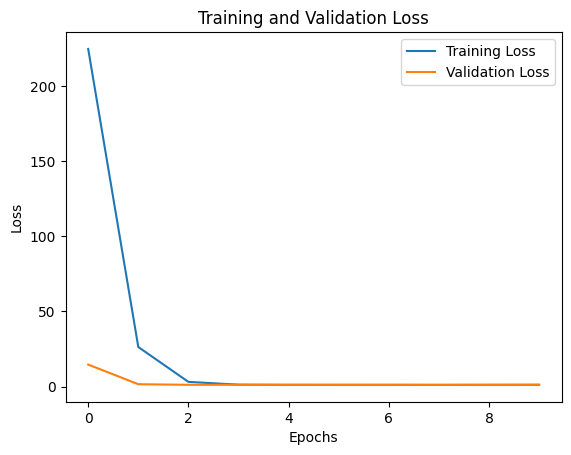

In [31]:
###Second Setup with more Diagnostics included###

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.metrics import average_precision_score

class CNNGCNModel(nn.Module):
    def __init__(self, num_classes, edge_index, cnn_output_dim=256, gcn_hidden_dim=128):
        super(CNNGCNModel, self).__init__()

        # CNN Component
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(128 * 56 * 56, cnn_output_dim),
            nn.ReLU()
        )

        # GCN Component
        self.gcn1 = GCNConv(num_classes, gcn_hidden_dim)
        self.gcn2 = GCNConv(gcn_hidden_dim, gcn_hidden_dim)

        # Linear layer to project GCN output to cnn_output_dim
        self.gcn_project = nn.Linear(gcn_hidden_dim, cnn_output_dim)

        # Edge index
        self.edge_index = edge_index
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x, label_features):
        # CNN forward pass
        cnn_features = self.cnn(x)  # [batch_size, cnn_output_dim]
        print(f"CNN Features Shape: {cnn_features.shape}")

        # GCN forward pass
        label_embeddings = F.relu(self.gcn1(label_features, self.edge_index))  # [num_classes, gcn_hidden_dim]
        label_embeddings = self.dropout(label_embeddings)

        # Apply GCN2
        label_embeddings = label_embeddings + F.relu(self.gcn2(label_embeddings, self.edge_index))  # Skip connection
        print(f"GCN Intermediate Label Embeddings Shape: {label_embeddings.shape}")

        # Project label embeddings to match cnn_output_dim
        label_embeddings = self.gcn_project(label_embeddings)  # [num_classes, cnn_output_dim]
        print(f"GCN Final Label Embeddings Shape: {label_embeddings.shape}")

        # Combine CNN and GCN outputs
        logits = torch.matmul(cnn_features, label_embeddings.T)  # [batch_size, num_classes]
        return logits

# Initialize weights
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
    elif hasattr(m, 'weight') and m.weight is not None:  # For GCNConv layers
        nn.init.xavier_uniform_(m.weight)

# Loss function with class imbalance handling
def compute_class_weights(labels):
    label_counts = labels.sum(axis=0)
    pos_weight = torch.tensor([1.0 / max(count, 1e-6) for count in label_counts], dtype=torch.float32)
    return pos_weight

# Evaluate mAP
def calculate_map(logits, labels):
    probs = torch.sigmoid(logits).detach().cpu().numpy()
    labels = labels.cpu().numpy()
    return average_precision_score(labels, probs, average="macro")

# Training and Validation Loop
def train_model(model, train_loader, val_loader, criterion, optimizer, label_features, num_epochs=10):
    train_losses, val_losses = [], []
    for epoch in range(num_epochs):
        # Training
        model.train()
        total_train_loss = 0
        for batch in train_loader:
            images = batch['image']
            labels = batch['label']

            optimizer.zero_grad()
            logits = model(images, label_features)
            loss = criterion(logits, labels)
            loss.backward()

            # Check gradients
            for name, param in model.named_parameters():
                if param.grad is not None:
                    print(f"Parameter: {name}, Gradient Mean: {param.grad.mean().item()}, Gradient Std: {param.grad.std().item()}")

            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        all_val_logits, all_val_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                images = batch['image']
                labels = batch['label']

                logits = model(images, label_features)
                loss = criterion(logits, labels)
                total_val_loss += loss.item()

                all_val_logits.append(logits)
                all_val_labels.append(labels)

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Compute validation mAP
        all_val_logits = torch.cat(all_val_logits, dim=0)
        all_val_labels = torch.cat(all_val_labels, dim=0)
        val_map = calculate_map(all_val_logits, all_val_labels)

        print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation mAP: {val_map:.4f}")

    return train_losses, val_losses

# Model, Optimizer, and Training Setup
num_classes = 25  # Number of labels
edge_index = torch.tensor([[0, 1, 2], [0, 1, 2]], dtype=torch.long)  # Replace with your actual edge index
label_features = torch.eye(num_classes)

model = CNNGCNModel(num_classes, edge_index)
model.apply(init_weights)

# Compute class weights
def compute_class_weights(labels):
    """
    Compute class weights for imbalanced datasets.
    Parameters:
        labels (np.ndarray): Array of shape [num_samples, num_classes].
    Returns:
        torch.Tensor: Class weights for each class.
    """
    total_samples = labels.shape[0]
    pos_counts = labels.sum(axis=0)
    neg_counts = total_samples - pos_counts
    class_weights = neg_counts / pos_counts
    return torch.tensor(class_weights, dtype=torch.float32)
# Load the CSV file
csv_file = pd.read_csv("train.csv")  # Ensure the CSV matches the expected format

# Split the CSV into train and validation
train_csv, val_csv = train_test_split(csv_file, test_size=0.15, random_state=42)

# Define the paths
image_dir = "/content/drive/My Drive/Multi_Label_dataset/Images"

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# Initialize the dataset and dataloaders
train_dataset = ImageDataset(train_csv, train=True, test=False)
val_dataset = ImageDataset(val_csv, train=False, test=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Compute class weights using the training labels
pos_weight = compute_class_weights(train_dataset.all_labels)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Initialize and train the model
model = CNNGCNModel(num_classes, edge_index)
model.apply(init_weights)

train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, label_features)

pos_weight = compute_class_weights(train_dataset.all_labels)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, label_features)

# Plotting loss curves
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()
